<h2 style='color:blue' align='center'>Transfer learning in image classification</h2>

**In this notebook we will use transfer learning and take pre-trained model from google's Tensorflow Hub and re-train that on plant dataset. Using pre-trained model saves lot of time and computational budget for new classification problem at hand**

In [ ]:
# Install tensorflow_hub using pip install tensorflow_hub first

In [8]:
import numpy as np
import cv2

import PIL.Image as Image
import PIL
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Make predictions using ready made model (without any training)**

In [ ]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

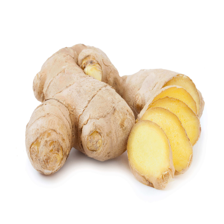

In [9]:
ginger = Image.open("/content/drive/MyDrive/final_ML/ginger-scaled.png").resize(IMAGE_SHAPE)
ginger

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
ginger = np.array(ginger)/255.0
ginger.shape

(224, 224, 3)

In [11]:
ginger[np.newaxis, ...]

array([[[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]]])

In [12]:
result = classifier.predict(ginger[np.newaxis, ...])
result.shape

1/1 [==============================] - 1s 1s/step


(1, 1001)

In [13]:
predicted_label_index = np.argmax(result)
predicted_label_index

931

In [15]:
# tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
image_labels = []
with open("/content/drive/MyDrive/final_ML/ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [16]:
image_labels[predicted_label_index]

'French loaf'

<h3 style='color:purple'>Load plants dataset</h3>

In [ ]:
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/plant_photos.tgz"
# data_dir = tf.keras.utils.get_file('plant_photos', origin=dataset_url,  cache_dir='.', untar=True)
# # cache_dir indicates where to download data. I specified . which means current directory
# # untar true will unzip it

In [17]:
data_dir = '/content/drive/MyDrive/final_ML/dataset'

In [18]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/drive/MyDrive/final_ML/dataset')

In [19]:
list(data_dir.glob('*/*.png'))[:5]

[PosixPath('/content/drive/MyDrive/final_ML/dataset/galangals/Screenshot 2024-03-13 044639.png'),
 PosixPath('/content/drive/MyDrive/final_ML/dataset/galangals/Screenshot 2024-03-13 044628.png'),
 PosixPath('/content/drive/MyDrive/final_ML/dataset/galangals/Screenshot 2024-03-13 044537.png'),
 PosixPath('/content/drive/MyDrive/final_ML/dataset/galangals/Screenshot 2024-03-13 044617.png'),
 PosixPath('/content/drive/MyDrive/final_ML/dataset/galangals/Screenshot 2024-03-13 044604.png')]

In [20]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

260


In [22]:
gingers = list(data_dir.glob('gingers/*'))
gingers[:5]

[PosixPath('/content/drive/MyDrive/final_ML/dataset/gingers/honey-lemon-ginger-juice-food-beverage-products-from-ginger-extract-food-nutrition-concept.png'),
 PosixPath('/content/drive/MyDrive/final_ML/dataset/gingers/fresh-ginger-root.png'),
 PosixPath('/content/drive/MyDrive/final_ML/dataset/gingers/bittersweet-ginger.png'),
 PosixPath('/content/drive/MyDrive/final_ML/dataset/gingers/Screenshot 2024-03-13 040815.png'),
 PosixPath('/content/drive/MyDrive/final_ML/dataset/gingers/Screenshot 2024-03-13 040336.png')]

In [32]:
PIL.Image.open(str(gingers[1]))

Output hidden; open in https://colab.research.google.com to view.

<h3 style='color:purple'>Read plants images from disk into numpy array using opencv</h3>

In [28]:
plants_images_dict = {
    'gingers': list(data_dir.glob('gingers/*')),
    'galangals': list(data_dir.glob('galangals/*')),
    'white_turmerics': list(data_dir.glob('white_turmerics/*')),
}

In [29]:
plants_labels_dict = {
    'gingers': 0,
    'galangals': 1,
    'white_turmerics': 2,
}

In [30]:
plants_images_dict['gingers'][:5]

[PosixPath('/content/drive/MyDrive/final_ML/dataset/gingers/honey-lemon-ginger-juice-food-beverage-products-from-ginger-extract-food-nutrition-concept.png'),
 PosixPath('/content/drive/MyDrive/final_ML/dataset/gingers/fresh-ginger-root.png'),
 PosixPath('/content/drive/MyDrive/final_ML/dataset/gingers/bittersweet-ginger.png'),
 PosixPath('/content/drive/MyDrive/final_ML/dataset/gingers/Screenshot 2024-03-13 040815.png'),
 PosixPath('/content/drive/MyDrive/final_ML/dataset/gingers/Screenshot 2024-03-13 040336.png')]

In [33]:
str(plants_images_dict['gingers'][0])

'/content/drive/MyDrive/final_ML/dataset/gingers/honey-lemon-ginger-juice-food-beverage-products-from-ginger-extract-food-nutrition-concept.png'

In [35]:
img = cv2.imread(str(plants_images_dict['gingers'][0]))

In [36]:
img.shape

(3840, 5760, 3)

In [37]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [38]:
X, y = [], []

for plant_name, images in plants_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(plants_labels_dict[plant_name])

In [39]:
X = np.array(X)
y = np.array(y)

<h3 style='color:purple'>Train test split</h3>

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

<h3 style='color:purple'>Preprocessing: scale images</h3>

In [41]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

**Make prediction using pre-trained model on new plants dataset**

In [42]:
X[0].shape

(224, 224, 3)

In [43]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [44]:
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)

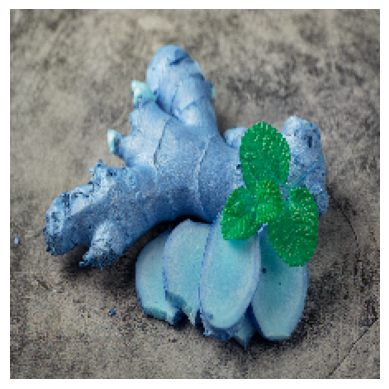

In [45]:
plt.axis('off')
plt.imshow(X[0])

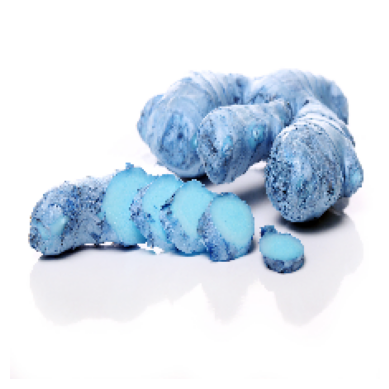

In [58]:
plt.axis('off')
plt.imshow(X[1])

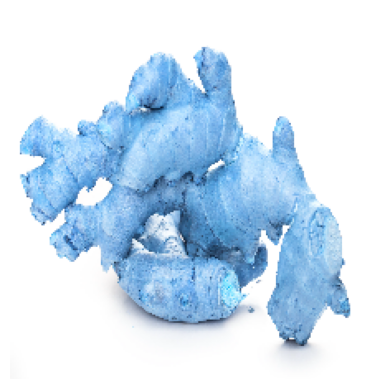

In [47]:
plt.axis('off')
plt.imshow(X[2])

In [49]:
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

1/1 [==============================] - 0s 306ms/step


array([795, 550, 550])

In [51]:
image_labels[550]

'envelope'

<h3 style='color:purple'>Now take pre-trained model and retrain it using plants images</h3>

In [52]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [60]:
num_of_plants = 3

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_plants)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [61]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
7/7 [==============================] - 9s 1s/step - loss: 1.1690 - acc: 0.4872
Epoch 2/5
7/7 [==============================] - 6s 773ms/step - loss: 0.7542 - acc: 0.6923
Epoch 3/5
7/7 [==============================] - 7s 1s/step - loss: 0.4191 - acc: 0.8615
Epoch 4/5
7/7 [==============================] - 6s 851ms/step - loss: 0.3185 - acc: 0.9179
Epoch 5/5
7/7 [==============================] - 7s 1s/step - loss: 0.2565 - acc: 0.9385


In [62]:
model.evaluate(X_test_scaled,y_test)

3/3 [==============================] - 3s 714ms/step - loss: 0.3317 - acc: 0.8769


[0.33165866136550903, 0.8769230842590332]